In [33]:
import numpy as np
import pandas as pd
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold


In [34]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

PassengerId = test['PassengerId']


In [35]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
full_data = [train, test]

In [37]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset["FamilySize"] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare']= pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
    
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset["Title"] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', "Capt", 'Col',
                                                 'Don', "Dr", 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mne', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({"female": 0, "male": 1}).astype(int)
    title_mapping = {"Mr": 1, "Miss":2, "Mrs": 3, "Master":4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map({"S": 0, "C":1, "Q":2}).astype(int)

    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.45), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.45) & (dataset['Fare'] <= 31 ), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 31, 'Fare')] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age'] >16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <=48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64) , 'Age'] = 4


In [38]:
train["Age"].unique()

array([1, 2, 3, 0, 4])

In [39]:
test["Age"].unique()

array([2, 3, 1, 0, 4])

In [40]:
drop_elemets = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train =train.drop(drop_elemets,axis=1)


In [44]:
train = train.drop(['CategoricalFare', 'CategoricalAge'],axis=1)


In [45]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0
3,1,1,0,2,0,3,0,44,1,2,0,3.0
4,0,3,1,2,0,1,0,24,0,1,1,1.0


<AxesSubplot:title={'center':'Peason Correlation of Features '}>

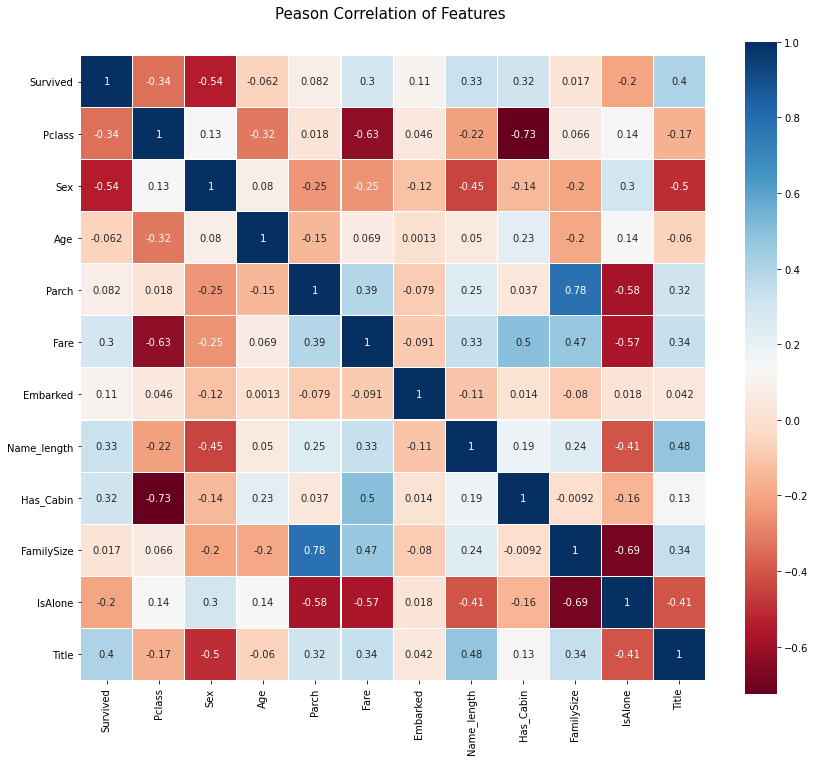

In [48]:
colormap = plt.cm.RdBu


plt.figure(figsize=(14,12))
plt.title("Peason Correlation of Features ", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)


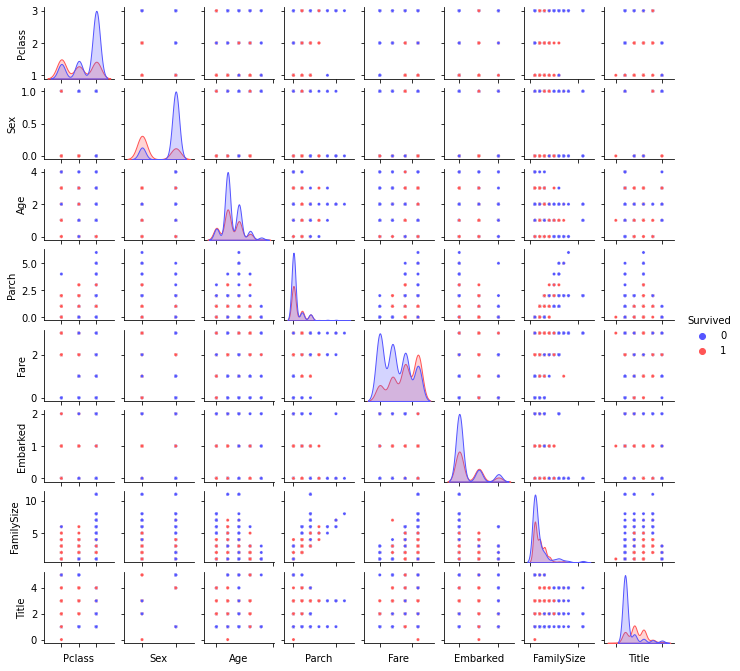

In [51]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', 
                    u'Fare', u'Embarked', u'FamilySize', u'Title']], hue='Survived',palette='seismic',
                    size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])
